# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [30]:

# import libraries
import re
import nltk
import pickle
import os
import sys
import json
from IPython.display import display, HTML

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.plotly as py
import plotly
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot
from plotly import tools

#plotly.offline.init_notebook_mode()
init_notebook_mode(connected = True)
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger','stopwords'])

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import multioutput
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score, fbeta_score, accuracy_score, classification_report, recall_score, precision_score

import scipy.stats.contingency as cont

%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Read Dataset from SQL

In [2]:

# Set column width to max for viewing
pd.set_option('max_colwidth', 200)
pd.set_option('display.precision', 3)

In [3]:
# load data from database


def load_db(db_path):

    # Create an SQLAlchemy engine
    engine = create_engine(f'sqlite:///{db_path}')

    # Extract the table name from the database filepath (excluding extension)
    table_name = os.path.splitext(os.path.basename(db_path))[0]

    # Save the DataFrame to the database, replace if it already exists
    df = pd.read_sql(f'select * from {table_name}', engine)    

    return df


In [4]:
# Test reading database

db_df = load_db(os.path.join(os.getcwd(), 'disaster_response.db'))
print(db_df.shape)

db_df.head()

(26216, 40)


,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,no_label
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,8,Looking for someone but no name,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
db_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,26216.0,15224.821,8826.889,2.0,7446.75,15662.5,22924.25,30265.0
related,26216.0,0.766,0.423,0.0,1.00,1.0,1.00,1.0
request,26216.0,0.171,0.376,0.0,0.00,0.0,0.00,1.0
offer,26216.0,0.005,0.067,0.0,0.00,0.0,0.00,1.0
aid_related,26216.0,0.414,0.493,0.0,0.00,0.0,1.00,1.0
medical_help,26216.0,0.079,0.271,0.0,0.00,0.0,0.00,1.0
medical_products,26216.0,0.050,0.218,0.0,0.00,0.0,0.00,1.0
search_and_rescue,26216.0,0.028,0.164,0.0,0.00,0.0,0.00,1.0
security,26216.0,0.018,0.133,0.0,0.00,0.0,0.00,1.0
military,26216.0,0.033,0.178,0.0,0.00,0.0,0.00,1.0


<p>
    <strong>Important Note:</strong> During exploring the data, it was found out that around 6,000 rows of messages didn't have labels. 
    These messages turned out to be not related to disasters, according to the 
    <span style="background-color:yellow;">source of information below</span>. 
    So, only ~ 20K records that do have labels will be utilized for model training. 
   
</p>

<b>Note:</b> Source - <a href="https://github.com/rmunro/disaster_response_messages">https://github.com/rmunro/disaster_response_messages</a>

<ul style="font-size: small;">
    <li><b>-related:</b> 0, 1 or 2, whether the message is related to a disaster (1 == yes, 0 == no, 2 == unsure)</li>
    <li><b>-request:</b> 0 or 1, whether the message is a request for aid</li>
    <li><b>-offer:</b> 0 or 1, whether the message is offering help</li>  
    <li><b>-direct_report:</b> 0 or 1, whether the message is a direct report from someone experiencing/witnessing the disaster or if they are reporting second/third hand</li>
</ul>    
<p> Aid Related </p>
<ul style="font-size: small;">
    <li><b>-aid_related:</b> 0 or 1, whether the message is related to aid</li>
    <li><b>-medical_help:</b> 0 or 1, whether the message is about medical help</li>
    <li><b>-medical_products:</b> 0 or 1, whether the message is about medical products</li>
    <li><b>-search_and_rescue:</b> 0 or 1, whether the message is about search and rescue</li>
    <li><b>-security:</b> 0 or 1, whether the message is about personal security</li>    
    <li><b>-search_and_rescue: 0 or 1, whether the message is about search and rescue</li>
    <li><b>-security: 0 or 1, whether the message is about personal security</li>
    <li><b>-military: 0 or 1, whether the message is about military actions</li>
    <li><b>-child_alone: 0 or 1, whether the message is about a child/children who are without adult care (all 0 in this public release)</li>
    <li><b>-water: 0 or 1, whether the message is about drinking water</li>
    <li><b>-food: 0 or 1, whether the message is about food</li>
    <li><b>-shelter: 0 or 1, whether the message is about shelter</li>
    <li><b>-clothing: 0 or 1, whether the message is about clothing</li>
    <li><b>-money: 0 or 1, whether the message is about money</li>
    <li><b>-missing_people: 0 or 1, whether the message is about missing people</li>
    <li><b>-refugees: 0 or 1, whether the message is about refugees or internally displaced people</li>
    <li><b>-death: 0 or 1, whether the message is about death</li>
    <li><b>-other_aid: 0 or 1, whether the message is about another aid-related topic</li>
</ul>    
<p> Infrastructure Related </p>
<ul style="font-size: small;">
    <li><b>-infrastructure_related: 0 or 1, whether the message is about infrastructure-related issues</li>
    <li><b>-transport: 0 or 1, whether the message is about transport like buses, trains, planes, boats, taxis, bicycles, etc. and interuptions to transport like blocked roads or missing bridges.</li>
    <li><b>-buildings: 0 or 1, whether the message is related to buildings: unstable, collapsed, inundated, usable as shelters, etc.</li>
    <li><b>-electricity: 0 or 1, whether the message is related to power infrastructure, including public utilities and private generators</li>
    <li><b>-tools: 0 or 1, whether the message is about tools related to disaster prevention and response</li>
    <li><b>-hospitals: 0 or 1, whether the message is related to infrastructure for medical care, including hospitals and makeshift clinics</li>
    <li><b>-shops: 0 or 1, whether the message is related to shops, markets, and other places of commerce, real or online</li>
    <li><b>-aid_centers: 0 or 1, whether the message is related to aid_centers</li>
    <li><b>-other_infrastructure: 0 or 1, whether the message is related to other types of disaster-related infrastructure</li>
</ul>    
<p> Weather Related </p>
<ul style="font-size: small;">
<li><b>-weather_related: whether the message is weather-related</li>
<li><b>-floods: 0 or 1, whether the message is related to flooding</li>
<li><b>-storm: 0 or 1, whether the message is related to storms, including hurricanes, tornadoes and snow-storms</li>
<li><b>-fire: 0 or 1, whether the message is related to fire, including house fires and bush/forest fires</li>
<li><b>-earthquake: 0 or 1, whether the message is related to earthquakes</li>
<li><b>-cold: 0 or 1, whether the message is related to dangers from cold weather</li>
<li><b>-other_weather: 0 or 1, whether the message is related to other weather events</li>    
</ul>

#### Define feature and target variables X and Y

In [6]:
# Define feature and target variables X and Y
# Note Y is a multiple Y labels

def create_xy(df, nolabel: bool):
    
    # exlcude rows with missing labels if True
    if nolabel:
        df_temp = df[df['no_label'] != 1].copy()

    else:
        df_temp = df.copy()

    # exclude columns with extreme rare cases or those with no variability

    # Calculate the mean for each column
    column_means = df_temp.iloc[:, 3:-1].mean()

    # Calculate the mean for each column
    column_std = df_temp.iloc[:, 3:-1].std()

    remove_columns = list(set([col for col in column_means.index if (column_means[col] < 0.01 or column_means[col] > 0.9) ] + [col for col in column_std.index if column_std[col] <= 0.00]))
    print('Columns to be removed:', (remove_columns), df_temp.shape)

    df_temp.drop(labels=remove_columns, axis=1, inplace=True )
    print('Columns Removed:', df_temp.shape, '\n')        

    X = df_temp['message']
    y = df_temp.iloc[:,3:-1]
    print(f'Extracted X,y: missing labels removed {nolabel}', X.shape, y.shape, '\n')

    return X,y


In [7]:
# Test creating X and y

Xdump, ydump = create_xy(db_df, True)
ydump.head()

Columns to be removed: ['shops', 'tools', 'offer', 'child_alone', 'related'] (20094, 40)
Columns Removed: (20094, 35) 

Extracted X,y: missing labels removed True (20094,) (20094, 31) 



,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function and and customer features classes to process your text data 

In [8]:
# search patterns to be replace by a blank

url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
phone_pattern =  r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}'
email_pattern = r'[a-zA-Z0-9+_\-\.]+@[0-9a-zA-Z][.-0-9a-zA-Z]*.[a-zA-Z]+'

def CustomTokenize(text):

    """
    This function performs custom text tokenization by normalizing text, removing specified patterns,
    removing stopwords, tokenizing, and lemmatizing the text.

    Parameters:
    text (str): The input text to be tokenized.

    Returns:
    list of str: List of tokenized and lemmatized words.
    """    
    
    # normalize text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    text = re.sub(r'(?:\b\d+\b)', ' ', text)    
    #text = re.sub(r'\s\d+(\s\d+)*\s', ' ', text)
    
    for regexp in [url_pattern, phone_pattern, email_pattern]:            
        patterns = re.findall(regexp, text)
        for extract in patterns:
            text = text.replace(extract, ' ')
            
    # stopword list 
    stop_words = stopwords.words("english")
        
    # tokenize
    words = word_tokenize(text)
        
    # lemmatize
    words_lemmed = [WordNetLemmatizer().lemmatize(w).strip() for w in words if w not in stop_words]

    return words_lemmed


In [9]:
# Test tokenizer

for i in range(0,5):
    print(CustomTokenize(Xdump[i]))

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']
['hurricane']
['looking', 'someone', 'name']
['un', 'report', 'leogane', 'destroyed', 'hospital', 'st', 'croix', 'functioning', 'need', 'supply', 'desperately']
['say', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight']


In [10]:

class CustomTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):

        """
        CustomTokenizer constructor to initialize patterns for text tokenization.

        Patterns:
        - url_pattern: Regular expression pattern for URLs
        - phone_pattern: Regular expression pattern for phone numbers
        - email_pattern: Regular expression pattern for email addresses
        """
        # Define patterns to be replaced
        self.url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        self.phone_pattern = r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}'
        self.email_pattern = r'[a-zA-Z0-9+_\-\.]+@[0-9a-zA-Z][.-0-9a-zA-Z]*.[a-zA-Z]+'
        
    def tokenize(self, text):

        """
        Tokenize and preprocess text.

        Parameters:
        text (str): The input text to be tokenized and preprocessed.

        Returns:
        list of str: List of tokenized and preprocessed words.
        """
                
        # Normalize text
        text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

        # Replace number sequences bounded by spaces
        text = re.sub(r'\s\d+(\s\d+)*\s', ' ', text)

        # Replace patterns defined in the constructor
        for regexp in [self.url_pattern, self.phone_pattern, self.email_pattern]:            
            patterns = re.findall(regexp, text)
            for extract in patterns:
                text = text.replace(extract, " ")
        
        # Stopword list
        stop_words = stopwords.words("english")
        
        # Tokenize and lemmatize
        words = word_tokenize(text)
        words_lemmed = [WordNetLemmatizer().lemmatize(w) for w in words if w not in stop_words]

        return words_lemmed

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return [self.tokenize(text) for text in X]


In [11]:

# test tokenize function with TfidVectorizer

vectorizer = TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=5,  use_idf=True )
tdif_vectors = vectorizer.fit_transform(Xdump[:1000])

print(len(vectorizer.get_feature_names()))
vectorizer.get_feature_names()[75:125]

496


['clercine',
 'close',
 'clothes',
 'clothing',
 'cold',
 'cold front',
 'collapsed',
 'college',
 'come',
 'come help',
 'come see',
 'coming',
 'committee',
 'cost',
 'could',
 'counting',
 'country',
 'croix',
 'croix de',
 'cross',
 'cuba',
 'cuba morning',
 'cyber',
 'cyber cafe',
 'day',
 'de',
 'de bouquet',
 'de paix',
 'dead',
 'death',
 'delma',
 'delmas',
 'department',
 'destroyed',
 'die',
 'died',
 'difficult',
 'digicel',
 'disaster',
 'distribution',
 'doctor',
 'done',
 'dont',
 'drink',
 'du',
 'dying',
 'dying hunger',
 'earthquake',
 'eat',
 'emergency']

In [12]:
# viewing TD-IDF values

# get the first vector out (for the first document) 
# place tf-idf values in a pandas data frame 

tdidf_df = pd.DataFrame(tdif_vectors[0].T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"]) 
tdidf_df.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
front cuba,0.398
pas,0.388
cold front,0.380
cuba,0.359
front,0.359
cold,0.343
could,0.305
haiti,0.278
people coming,0.000
plaine,0.000


**Note:  The size of token matrix is still large after applying minimum requirement that word occurs in at least 5 rows.**

####  Create Features and Test Correlation with Categorical Labels

In [13]:

class CustomFeaturesExtractor(BaseEstimator, TransformerMixin):

    """
    CustomFeaturesExtractor class for extracting specific features from text.

    This class defines methods to extract various linguistic features from text,
    such as verb and noun percentages, tweet counts, and message lengths.

    Attributes:
    None
    """

    def extract_features(self, text):
        
        """
        Extract linguistic features from text.

        Parameters:
        text (str): The input text from which features will be extracted.

        Returns:
        tuple: A tuple containing extracted features:
            - verb_pct (float): Percentage of verbs in the text.
            - noun_pct (float): Percentage of nouns in the text.
            - tweet_cnt (int): Count of "RT" (retweet) occurrences in the text.
            - message_length (int): Total length of the text in terms of word tokens.
        """

        # Initialize counts and total sentence length
        verb_count = 0
        noun_count = 0
        message_length = 0
        sentence_count = 0
        word_count = 0
        tweet_count = 0

        # Tokenize by sentences
        sentence_list = sent_tokenize(text)

        for sentence in sentence_list:
            # Tokenize each sentence into words and tag part of speech
            pos_tags = pos_tag(word_tokenize(sentence))
            first_word, first_tag = pos_tags[0]            
            if first_word == 'RT':    
                tweet_count += 1               

            # Update sentence count
            sentence_count += 1

            # Update total sentence length
            message_length += len(pos_tags)
            
            # Count verbs and nouns in the sentence
            for word, tag in pos_tags:
                word_count +=1
                if tag.startswith('VB'):  # Verb tags start with 'VB'
                    verb_count += 1
                elif tag.startswith('NN'):  # Noun tags start with 'NN'
                    noun_count += 1
                #elif tag.startswith('RB'):  # Adverb tags start with 'RB'
                #    adverb_count += 1
  
        # Calculate average sentence length
        #avg_sentence_length = total_sentence_length / sentence_count if sentence_count > 0 else 0        

        return verb_count/(word_count+0.01), noun_count/(word_count+0.01), tweet_count, message_length

    def fit(self, x, y=None):
        return self

    def transform(self, X):

        # Apply extract_features function to all values in X
        features = pd.Series(X).apply(self.extract_features)
        features_df = features.apply(pd.Series)

        # Rename columns for clarity
        features_df.columns = ['verb_pct', 'noun_pct', 'tweet_cnt', 'message_length']

        return features_df


In [14]:
# Test Feature Extractor

extractor = CustomFeaturesExtractor()
features_df = extractor.fit_transform(Xdump)

In [15]:
# inspect features
features_df.head()

,verb_pct,noun_pct,tweet_cnt,message_length
0,0.077,0.307,0.0,13.0
1,0.222,0.111,0.0,9.0
2,0.166,0.333,0.0,6.0
3,0.000,0.625,0.0,16.0
4,0.071,0.428,0.0,14.0


In [16]:
# run statistics
features_df.describe()

,verb_pct,noun_pct,tweet_cnt,message_length
count,20094.000,20094.000,20094.000,20094.000
mean,0.150,0.324,0.011,28.652
std,0.076,0.131,0.106,40.279
min,0.000,0.000,0.000,0.000
25%,0.100,0.250,0.000,17.000
50%,0.143,0.312,0.000,25.000
75%,0.200,0.381,0.000,34.000
max,0.571,1.000,2.000,1913.000


In [17]:
# Correlation of Custom Text Features with Category Labels

corr_df = pd.concat([features_df, ydump], axis=1)
corr_matrix = corr_df.corr()

corr_features = corr_matrix.loc[:,features_df.columns]
corr_features.drop(features_df.columns, axis=0, inplace=True)
corr_features.reset_index(inplace=True)
corr_features

,index,verb_pct,noun_pct,tweet_cnt,message_length
0,request,1.705e-01,-0.071,-2.521e-02,-0.029
1,aid_related,5.605e-02,-0.003,-3.564e-02,0.094
2,medical_help,-2.421e-02,0.002,-1.998e-02,0.130
3,medical_products,-6.719e-02,0.062,-1.610e-02,0.129
4,search_and_rescue,5.529e-03,0.016,7.531e-03,0.055
5,security,-4.896e-04,0.002,-3.721e-03,0.049
6,military,-2.637e-02,-0.004,-2.195e-02,0.082
7,water,-3.413e-02,0.057,-2.620e-02,0.120
8,food,2.487e-02,0.020,-3.886e-02,0.086
9,shelter,2.893e-02,-0.011,-3.159e-02,0.114


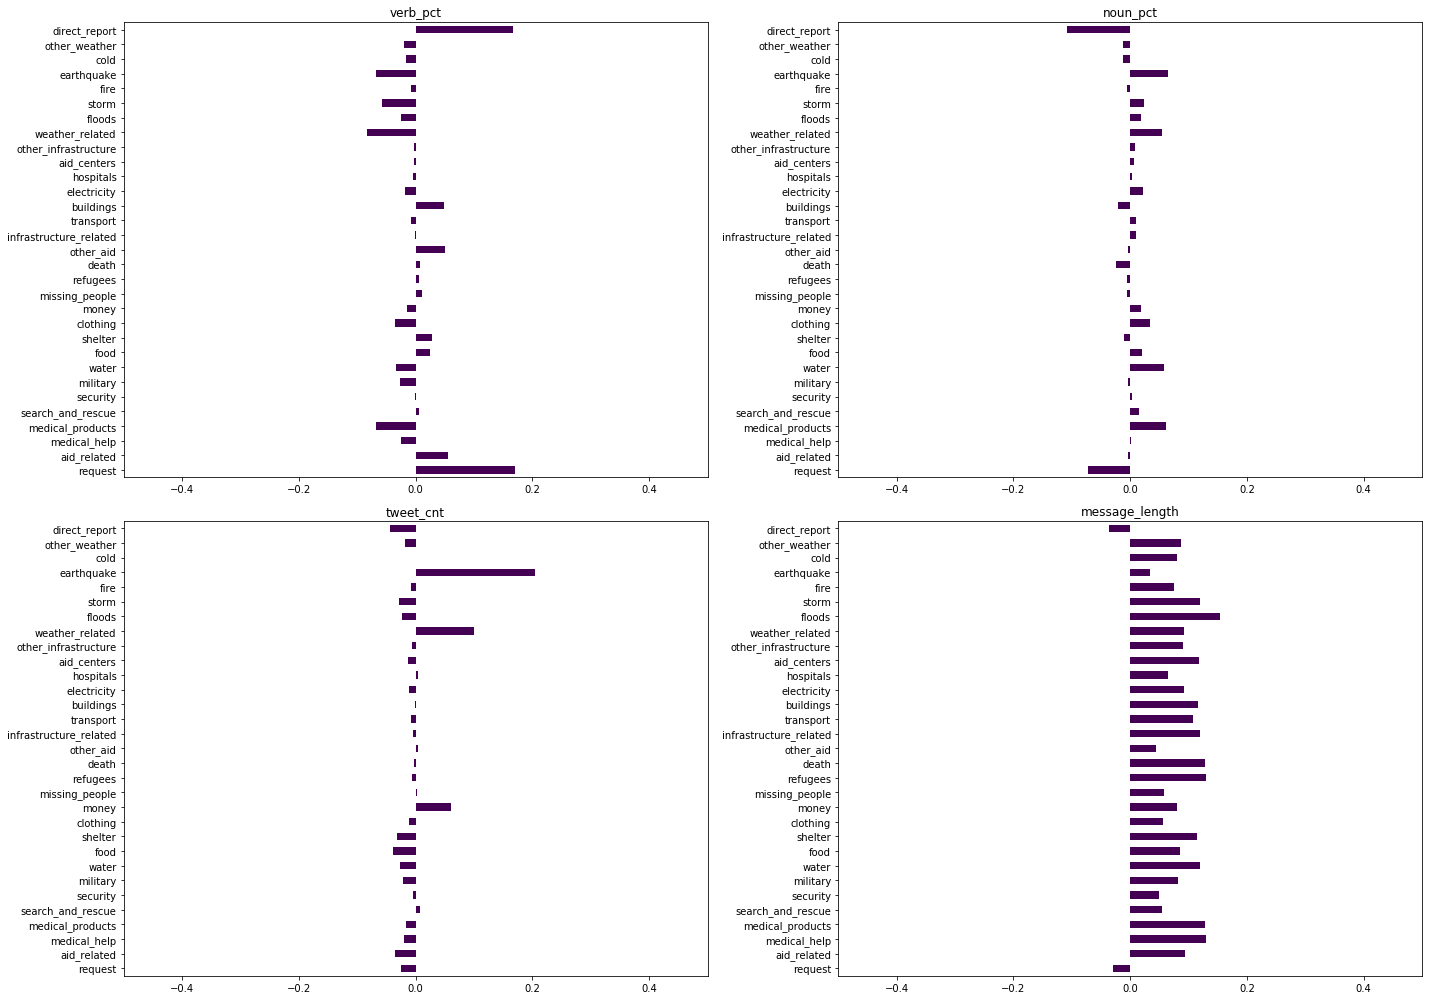

In [18]:

cmap = plt.cm.viridis

# Set up a figure with 1 row and 3 columns for subplots

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))  # Adjust the figsize as needed

# Iterate over your features and create a plot for each
for i, feature in enumerate(['verb_pct', 'noun_pct', 'tweet_cnt', 'message_length']):

    # Calculate row and column for subplot
    row = i // 2  # Integer division
    col = i % 2   # Modulo for column

    # Get the number of bars in the plot
    num_bars = len(corr_features[feature])

    # Get a color for each bar based on the colormap
    bar_colors = cmap(np.linspace(0, 1, num_bars))
    
    # Plotting the data
    corr_features[feature].plot.barh(ax=axes[row,col], xlim=[-0.5, 0.5], color=bar_colors)

    # Setting the title for each subplot
    axes[row,col].set_title(feature)

    # Setting the y-axis labels using the index of the DataFrame
    axes[row,col].set_yticklabels(corr_features['index'])    

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [19]:
# Building the pipeline

pipeline_basic = Pipeline([
    # Text Extraction Process
    ('features', FeatureUnion([
        ('text_features', Pipeline([
            ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize , ngram_range=(1, 2), min_df=5))
        ])),
        ('custom_features', CustomFeaturesExtractor())
    ])),
    # Base Model - Logistic Regression
    ('estimator', MultiOutputClassifier(LogisticRegression()))    
])

In [20]:

def build_pipeline(estimator, custom: bool, grid: bool):

    """
    Build a machine learning pipeline for text classification.

    This function constructs a pipeline for text classification tasks. It allows the selection of different
    base estimators (classifiers) and provides options for custom feature extraction and grid search.

    Parameters:
    estimator (str): The choice of base estimator for classification ('RF' for RandomForestClassifier,
                     'GBM' for GradientBoostingClassifier, 'SVC' for LinearSVC, or any other value for
                     LogisticRegression).
    custom (bool): Whether to include custom feature extraction using 'CustomFeaturesExtractor'.
    grid (bool): Whether to perform hyperparameter grid search using GridSearchCV.

    Returns:
    sklearn.pipeline.Pipeline: A machine learning pipeline configured based on the input parameters.

    Example Usage:
    pipeline = build_pipeline('RF', custom=True, grid=True)
    """    

    # Select the base model and set grid search parameters
    if estimator == 'RF':
        model = RandomForestClassifier(min_samples_split=25)
        grid_param = {
            'estimator__estimator__max_depth': [5,7],            
            'estimator__estimator__n_estimators': [250, 500],
            'estimator__estimator__class_weight': [None, 'balanced']                                                   
        }
    elif estimator == 'GBM':
        model = GradientBoostingClassifier(min_samples_leaf=50)
        grid_param = {
            'estimator__estimator__max_depth': [5,7],
            'estimator__estimator__n_estimators': [500],
            'estimator__estimator__learning_rate': [0.01]
        }
    elif estimator == 'SVC':
        model = LinearSVC(penalty='l2', loss='squared_hinge', dual=False)
        grid_param = {
            'estimator__estimator__C': [0.01, 0.1, 1, 10],
            'estimator__estimator__class_weight': [None, 'balanced']
        }
    else:  # Default to Logistic Regression
        model = LogisticRegression()
        grid_param = {
            'estimator__estimator__C': [0.01, 0.1, 1, 10],
            'estimator__estimator__class_weight': [None, 'balanced']
        }

    # Standard Pipeline
    pipeline_standard = Pipeline([
        ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6)),
        ('estimator', MultiOutputClassifier(model))
    ])

    # Custom Pipeline
    pipeline_custom = Pipeline([
        ('features', FeatureUnion([
            ('text_features', Pipeline([
                ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6))
            ])),
            ('custom_features', CustomFeaturesExtractor())
        ])),
        ('estimator', MultiOutputClassifier(model))
    ])

    # Determine which pipeline to use
    pipeline = pipeline_custom if custom else pipeline_standard

    if estimator == 'GBM':
        cv=2
    else:
        cv=5

    # Apply GridSearchCV if needed
    if grid:
        grid_pipeline = GridSearchCV(pipeline, param_grid=grid_param, cv=cv)  # Adjust cv as needed
        return grid_pipeline

    return pipeline


##### Build a Model Pipeline 
- create a model pipeline
- validate model performance
- conduct grid search

In [21]:
#  test the pipeline

pipeline_test = build_pipeline('SVC', True, True)
print(pipeline_test.get_params)
#print(pipeline_test.named_steps)


<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text_features', Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True,...ti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__estimator__C': [0.01, 0.1, 1, 10], 'estimator__estimator__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>


In [22]:
# run a report on model performance

def display_metrics(y_actual, y_pred):
    """
    Display classification performance metrics for a multi-label classification model.

    This function takes the actual labels (y_actual) and predicted labels (y_pred) for a multi-label classification
    problem and calculates various performance metrics for each label, including precision, recall, F1-score, support,
    and accuracy. The metrics are displayed in a pandas DataFrame sorted by F1-score in descending order.

    Parameters:
    y_actual (DataFrame): The actual labels for each sample.
    y_pred (DataFrame): The predicted labels for each sample.

    Returns:
    DataFrame: A DataFrame containing precision, recall, F1-score, support, and accuracy for each label.

    Example Usage:
    metrics_df = display_metrics(y_actual, y_pred)
    print(metrics_df)
    """    

    print('Model Performance:')
    #print(classification_report(y_actual, y_pred, target_names=y_actual.columns))

    metrics_ = []
    for i in range(y_actual.shape[1]):
        precision_, recall_, f1_score_, support_ = precision_recall_fscore_support(y_actual.iloc[:,i], y_pred[:,i])        
        acc_ = accuracy_score(y_actual.iloc[:, i], y_pred[:, i])            
        metrics_.append([y_actual.columns[i], precision_[1], recall_[1], f1_score_[1], support_[1], acc_])  

    # read into pandas DF
    model_metrics = pd.DataFrame(metrics_, columns=['feature','precision', 'recall', 'f1_score','support', 'accuracy'], dtype='float')

    # set data types for each column except 'feature'
    #float_cols = ['precision', 'recall', 'f1_score', 'accuracy']
    #for col in float_cols:
    #    model_metrics[col] = model_metrics[col].astype(float)

    # 'support' should be an integer
    model_metrics['support'] = model_metrics['support'].astype(int)

    model_metrics.sort_values(by=['f1_score'], ascending=False, inplace=True)

    return model_metrics


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

** Baseline Models would be conducted Logistic, LInear SVC, RandomForest, GradientBoost**  
<<   Note:  MISSING LABELS MESSAGES ARE NON-RLATED TO DISASTER >>

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

**In disaster response with unbalanced data, precision ensures accurate predictions and efficient resource use, while recall is crucial for identifying all actual needs in critical situations. The F1 score, a balanced measure of precision and recall, is especially relevant when false positives and negatives carry similar costs.**  

**For simplicity in this exercise, the F1 score for the positive label will be the basis for evaluating the metric as this  provides a clearer indication of the model's effectiveness.**

**When evaluating a model's performance, models with a higher number of F1 scores exceeding 0.5 would be prioritized. This indicates above-average performance and helps us select the most effective models.**

#### Baseline Models  
In the initial round of model training, we will establish baseline models using Logistic Regression, Linear SVC, Random Forest, and Gradient Boost.

In [288]:
# Create dataset of X,y with missing labels removed

Xmiss, ymiss = create_xy(db_df, True)
print(ymiss.shape, '\n', ymiss.columns)

ycol_names = ymiss.columns
print(ycol_names.tolist(),'\n')

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xmiss, ymiss, train_size=0.70)
print(Xm_train.shape, ym_train.shape, Xm_test.shape, ym_test.shape)

Columns to be removed: ['tools', 'offer', 'child_alone', 'related', 'shops'] (20094, 40)
Columns Removed: (20094, 35) 

Extracted X,y: missing labels removed True (20094,) (20094, 31) 

(20094, 31) 
 Index(['request', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'hospitals', 'aid_centers', 'other_infrastructure', 'weather_related',
       'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
['request', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'hospitals', 'aid_cente

c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [64]:

# Logistic with missing labels removed - standard pipeline no grid search

pipeline_baseline = build_pipeline('XX', False, False)
estimator_lr_ms = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_lr_ms.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_lr_ms = display_metrics(ym_test, ym_pred)
metrics_lr_ms

(6029, 31) (6029, 31) 

Model Performance:


c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.921,0.680,0.782,734,0.954
23,weather_related,0.858,0.704,0.773,2156,0.852
1,aid_related,0.771,0.754,0.763,3332,0.740
8,food,0.864,0.638,0.734,897,0.931
0,request,0.840,0.595,0.696,1379,0.881
7,water,0.821,0.544,0.654,522,0.950
30,direct_report,0.777,0.503,0.611,1546,0.836
25,storm,0.782,0.496,0.607,681,0.928
9,shelter,0.834,0.435,0.572,728,0.921
24,floods,0.933,0.399,0.559,664,0.931


In [65]:
# Linear SVC with missing labels removed - standard pipeline no grid search

pipeline_baseline = build_pipeline('SVC', False, False)
estimator_svc_ms = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_svc_ms.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_svc_ms = display_metrics(ym_test, ym_pred)
metrics_svc_ms

(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.898,0.752,0.818,734,0.959
8,food,0.858,0.738,0.793,897,0.943
23,weather_related,0.813,0.734,0.772,2156,0.845
1,aid_related,0.750,0.735,0.742,3332,0.718
7,water,0.812,0.678,0.739,522,0.959
0,request,0.768,0.629,0.691,1379,0.872
25,storm,0.727,0.627,0.674,681,0.931
24,floods,0.845,0.550,0.666,664,0.939
9,shelter,0.763,0.552,0.641,728,0.925
30,direct_report,0.691,0.557,0.617,1546,0.823


In [81]:
# Random Forest with missing labels removed  - standard pipeline no grid search

pipeline_baseline = build_pipeline('RF', False, False)
estimator_rf_ms = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_rf_ms.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_rf_ms = display_metrics(ym_test, ym_pred)
metrics_rf_ms

(6029, 31) (6029, 31) 

Model Performance:


c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.874,0.837,0.855,762,0.964
23,weather_related,0.823,0.766,0.793,2186,0.855
8,food,0.795,0.770,0.783,858,0.939
1,aid_related,0.712,0.803,0.755,3228,0.721
7,water,0.777,0.700,0.736,477,0.960
25,storm,0.749,0.679,0.712,707,0.936
0,request,0.788,0.558,0.654,1334,0.869
9,shelter,0.802,0.528,0.637,691,0.931
24,floods,0.848,0.503,0.632,612,0.940
14,death,0.808,0.440,0.569,364,0.960


In [67]:
# GradientBoosting without missing labels - standard pipeline no grid search

pipeline_baseline = build_pipeline('GBM', False, False)
estimator_gbm_ms = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_gbm_ms.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_gbm_ms = display_metrics(ym_test, ym_pred)
metrics_gbm_ms

(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.913,0.827,0.868,734,0.969
8,food,0.841,0.792,0.816,897,0.947
23,weather_related,0.892,0.653,0.754,2156,0.847
7,water,0.791,0.682,0.733,522,0.957
1,aid_related,0.773,0.690,0.729,3332,0.716
25,storm,0.783,0.651,0.711,681,0.940
10,clothing,0.800,0.603,0.688,126,0.989
24,floods,0.896,0.533,0.669,664,0.942
9,shelter,0.786,0.565,0.657,728,0.929
0,request,0.840,0.525,0.646,1379,0.868


In [ ]:
# GradientBoosting without missing labels - custom pipeline no grid search

pipeline_baseline = build_pipeline('GBM', True, False)
estimator_gbm_mc = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_gbm_mc.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_gbm_mc = display_metrics(ym_test, ym_pred)
metrics_gbm_mc

(5024, 31) (5024, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.887,0.849,0.867,655,0.966
8,food,0.820,0.802,0.811,737,0.945
23,weather_related,0.889,0.661,0.758,1878,0.843
7,water,0.744,0.746,0.745,413,0.958
1,aid_related,0.755,0.695,0.724,2688,0.716
25,storm,0.802,0.646,0.716,608,0.938
24,floods,0.866,0.577,0.692,560,0.943
9,shelter,0.793,0.534,0.639,539,0.935
0,request,0.810,0.504,0.621,1076,0.868
14,death,0.670,0.522,0.587,268,0.961


In [341]:
# List of your DataFrames and their corresponding new column names

metrics_dfs = [    
    (metrics_lr_ms, 'f1_score_lr_ms'),
    (metrics_svc_ms, 'f1_score_svc_ms'),
    (metrics_rf_ms, 'f1_score_rf_ms'),
    (metrics_gbm_ms, 'f1_score_gbm_ms')
]

# Initialize an empty DataFrame for merging
metrics_model_df = pd.DataFrame()

# Loop through each DataFrame, rename the 'f1_score' column, and merge
for df, new_column_name in metrics_dfs:
    df = df.rename(columns={'f1_score': new_column_name})[['feature',new_column_name]]
    if metrics_model_df.empty:
        metrics_model_df = df  # If merged_df is empty, initialize it with the first DataFrame
    else:
        metrics_model_df = pd.merge(metrics_model_df, df, on='feature', how='outer')

# Print the final merged DataFrame
display(metrics_model_df)

,feature,f1_score_lr_ms,f1_score_svc_ms,f1_score_rf_ms,f1_score_gbm_ms
0,earthquake,0.782,0.818,0.855,0.868
1,weather_related,0.773,0.772,0.793,0.754
2,aid_related,0.763,0.742,0.755,0.729
3,food,0.734,0.793,0.783,0.816
4,request,0.696,0.691,0.654,0.646
5,water,0.654,0.739,0.736,0.733
6,direct_report,0.611,0.617,0.553,0.539
7,storm,0.607,0.674,0.712,0.711
8,shelter,0.572,0.641,0.637,0.657
9,floods,0.559,0.666,0.632,0.669


In [342]:
f1_count = []
for col in metrics_model_df.columns:
    if col != 'feature':
        f1_count.append([col,sum(np.where(metrics_model_df[col] >= 0.5, 1,0))])
    #counts = filtered_data.value_counts()    
print("# F1 Scores >= 50%")
pd.DataFrame(f1_count, columns=['classifer','above_50'])

# F1 Scores >= 50%


,classifer,above_50
0,f1_score_lr_ms,10
1,f1_score_svc_ms,12
2,f1_score_rf_ms,11
3,f1_score_gbm_ms,12


### 6. Improve your model
Use grid search to find better parameters. 

#### Next, we perform model tuning through grid search, specifically focusing on Random Forest, Linear SVC, and Gradient Boost, with specific parameter configurations

In [24]:

# Create dataset of X,y with missing labels removed

Xgrid, ygrid = create_xy(db_df, True)
print(Xgrid.shape, '\n', ygrid.columns)

ycol_names = ygrid.columns
print(ycol_names.tolist(),'\n')

Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xgrid, ygrid, train_size=0.70)
print(Xg_train.shape, yg_train.shape, Xg_test.shape, yg_test.shape)

Columns to be removed: ['shops', 'tools', 'offer', 'child_alone', 'related'] (20094, 40)
Columns Removed: (20094, 35) 

Extracted X,y: missing labels removed True (20094,) (20094, 31) 

(20094,) 
 Index(['request', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'hospitals', 'aid_centers', 'other_infrastructure', 'weather_related',
       'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
['request', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'hospitals', 'aid_centers'

c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [291]:
# Random Forest with missing removed - standard pipeline with grid search

pipeline_baseline = build_pipeline('RF', False, True)
estimator_rf_mgs = pipeline_baseline.fit(Xg_train, yg_train)

yg_pred = estimator_rf_mgs.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

metrics_rf_mgs = display_metrics(yg_test, yg_pred)

print(estimator_rf_mgs.best_params_)
metrics_rf_mgs

(6029, 31) (6029, 31) 

Model Performance:
{'estimator__estimator__class_weight': 'balanced', 'estimator__estimator__max_depth': 7, 'estimator__estimator__n_estimators': 500}


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.859,0.748,0.799,765,0.952
23,weather_related,0.847,0.695,0.764,2219,0.842
8,food,0.733,0.793,0.762,878,0.928
7,water,0.657,0.767,0.708,519,0.945
1,aid_related,0.807,0.625,0.704,3284,0.714
25,storm,0.711,0.679,0.695,751,0.926
0,request,0.703,0.666,0.684,1361,0.861
30,direct_report,0.630,0.615,0.623,1518,0.812
9,shelter,0.577,0.658,0.615,761,0.896
24,floods,0.528,0.651,0.583,637,0.902


In [292]:
# Linear SVC with missing removed - standard pipeline with grid search

pipeline_baseline = build_pipeline('SVC', False, True)
estimator_svc_mgs = pipeline_baseline.fit(Xg_train, yg_train)

yg_pred = estimator_svc_mgs.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

metrics_svc_mgs = display_metrics(yg_test, yg_pred)

print(estimator_svc_mgs.best_params_)
metrics_svc_mgs


(6029, 31) (6029, 31) 

Model Performance:
{'estimator__estimator__C': 0.1, 'estimator__estimator__class_weight': None}


c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.925,0.706,0.801,765,0.955
23,weather_related,0.873,0.701,0.777,2219,0.852
1,aid_related,0.760,0.752,0.756,3284,0.735
8,food,0.847,0.663,0.744,878,0.933
0,request,0.846,0.579,0.688,1361,0.881
7,water,0.798,0.534,0.640,519,0.948
25,storm,0.811,0.497,0.616,751,0.923
30,direct_report,0.762,0.491,0.597,1518,0.833
24,floods,0.911,0.436,0.590,637,0.936
9,shelter,0.876,0.438,0.584,761,0.921


In [75]:

# GradientBoosting without missing labels - standard pipeline with grid search

pipeline_baseline = build_pipeline('GBM', False, True)
estimator_gbm_mgs = pipeline_baseline.fit(Xg_train, yg_train)

yg_pred = estimator_gbm_mgs.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

metrics_gbm_mgs = display_metrics(yg_test, yg_pred)
print('Best Parameter:', '\n', estimator_gbm_mgs.best_params_,'\n')

metrics_gbm_mgs

(6029, 31) (6029, 31) 

Model Performance:
Best Parameter: 
 {'estimator__estimator__learning_rate': 0.01, 'estimator__estimator__max_depth': 7, 'estimator__estimator__n_estimators': 500} 



c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.891,0.805,0.846,708,0.966
8,food,0.815,0.805,0.810,840,0.947
23,weather_related,0.880,0.655,0.751,2164,0.844
1,aid_related,0.764,0.692,0.726,3238,0.720
7,water,0.771,0.664,0.714,503,0.956
25,storm,0.761,0.668,0.712,711,0.936
24,floods,0.895,0.537,0.671,652,0.943
9,shelter,0.788,0.576,0.666,665,0.936
0,request,0.821,0.539,0.650,1311,0.874
10,clothing,0.702,0.602,0.648,98,0.989


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [293]:
# List of your DataFrames and their corresponding new column names

metrics_dfs = [        
    (metrics_svc_ms, 'f1_score_svc_ms'),
    (metrics_rf_ms, 'f1_score_rf_ms'),
    (metrics_gbm_ms, 'f1_score_gbm_ms'),
    (metrics_svc_mgs, 'f1_score_svc_mgs'),
    (metrics_rf_mgs, 'f1_score_rf_mgs'),
    (metrics_gbm_mgs, 'f1_score_gbm_mgs'),

]

# Initialize an empty DataFrame for merging
metrics_model_df = pd.DataFrame()

# Loop through each DataFrame, rename the 'f1_score' column, and merge
for df, new_column_name in metrics_dfs:
    df = df.rename(columns={'f1_score': new_column_name})[['feature',new_column_name]]
    if metrics_model_df.empty:
        metrics_model_df = df  # If merged_df is empty, initialize it with the first DataFrame
    else:
        metrics_model_df = pd.merge(metrics_model_df, df, on='feature', how='outer')

# Print the final merged DataFrame
display(metrics_model_df)

,feature,f1_score_svc_ms,f1_score_rf_ms,f1_score_gbm_ms,f1_score_svc_mgs,f1_score_rf_mgs,f1_score_gbm_mgs
0,earthquake,0.818,0.855,0.868,0.801,0.799,0.846
1,food,0.793,0.783,0.816,0.744,0.762,0.810
2,weather_related,0.772,0.793,0.754,0.777,0.764,0.751
3,aid_related,0.742,0.755,0.729,0.756,0.704,0.726
4,water,0.739,0.736,0.733,0.640,0.708,0.714
5,request,0.691,0.654,0.646,0.688,0.684,0.650
6,storm,0.674,0.712,0.711,0.616,0.695,0.712
7,floods,0.666,0.632,0.669,0.590,0.583,0.671
8,shelter,0.641,0.637,0.657,0.584,0.615,0.666
9,direct_report,0.617,0.553,0.539,0.597,0.623,0.533


In [340]:


f1_count = []
for col in metrics_model_df.columns:
    if col != 'feature':
        f1_count.append([col,sum(np.where(metrics_model_df[col] >= 0.5, 1,0))])
    #counts = filtered_data.value_counts()    
print("# F1 Scores >= 50%)")
pd.DataFrame(f1_count, columns=['classifer','above_50'])


# F1 Scores >= 50%)


,classifer,above_50
0,f1_score_svc_ms,12
1,f1_score_rf_ms,11
2,f1_score_gbm_ms,12
3,f1_score_svc_mgs,10
4,f1_score_rf_mgs,15
5,f1_score_gbm_mgs,12
6,f1_score_rf_mgc,14
7,f1_score_svc_mc,12


**With grid search, the F1 scores for RandomForest and GradientBoost models improved to 15 (from 11) and 14, respectively. It's worth noting that grid search for GradientBoost requires more computational resources.**

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

Custom text features, such as message length, the presence of action words indicating a call for help, and the presence of noun words within messages, will be  examined for their potential to enhance model performance.

In [78]:
# Random Forest with missing removed - custom pipeline with grid search

pipeline_baseline = build_pipeline('RF', True, True)
estimator_rf_mgc = pipeline_baseline.fit(Xg_train, yg_train)

yg_pred = estimator_rf_mgc.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

metrics_rf_mgc = display_metrics(yg_test, yg_pred)

print('Best Parameter:', '\n', estimator_rf_mgc.best_params_,'\n')
metrics_rf_mgc

(6029, 31) (6029, 31) 

Model Performance:
Best Parameter: 
 {'estimator__estimator__class_weight': 'balanced', 'estimator__estimator__max_depth': 7, 'estimator__estimator__n_estimators': 750} 



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.852,0.746,0.795,708,0.955
8,food,0.732,0.793,0.761,840,0.931
23,weather_related,0.834,0.682,0.750,2164,0.837
0,request,0.684,0.729,0.706,1311,0.868
1,aid_related,0.790,0.628,0.699,3238,0.710
7,water,0.635,0.746,0.686,503,0.943
25,storm,0.659,0.679,0.669,711,0.921
30,direct_report,0.604,0.644,0.623,1507,0.806
9,shelter,0.559,0.704,0.623,665,0.906
24,floods,0.510,0.690,0.586,652,0.895


In [84]:
# Linear SVC with missing labels removed - custom pipeline no grid search

pipeline_baseline = build_pipeline('SVC', True, False)
estimator_svc_mc = pipeline_baseline.fit(Xm_train, ym_train)

ym_pred = estimator_svc_mc.predict(Xm_test)
print(ym_pred.shape, ym_test.shape, '\n')

metrics_svc_mc = display_metrics(ym_test, ym_pred)
metrics_svc_mc

(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.902,0.751,0.819,762,0.958
8,food,0.819,0.723,0.768,858,0.938
23,weather_related,0.809,0.730,0.767,2186,0.840
1,aid_related,0.735,0.726,0.731,3228,0.713
7,water,0.742,0.633,0.683,477,0.954
25,storm,0.751,0.618,0.678,707,0.931
0,request,0.759,0.603,0.672,1334,0.870
24,floods,0.835,0.520,0.640,612,0.941
9,shelter,0.764,0.538,0.632,691,0.928
30,direct_report,0.669,0.534,0.594,1502,0.818


In [329]:

metrics_dfs = [        
    (metrics_lr_ms, 'f1_score_lr_ms'),
    (metrics_svc_ms, 'f1_score_svc_ms'),
    (metrics_rf_ms, 'f1_score_rf_ms'),
    (metrics_gbm_ms, 'f1_score_gbm_ms'),
    (metrics_svc_mgs, 'f1_score_svc_mgs'),
    (metrics_rf_mgs, 'f1_score_rf_mgs'),
    (metrics_gbm_mgs, 'f1_score_gbm_mgs'),
    (metrics_rf_mgc, 'f1_score_rf_mgc')
]

# Initialize an empty DataFrame for merging
metrics_model_f1 = pd.DataFrame()

# Loop through each DataFrame, rename the 'f1_score' column, and merge
for df, new_column_name in metrics_dfs:
    df = df.rename(columns={'f1_score': new_column_name})[['feature',new_column_name]]
    if metrics_model_f1.empty:
        metrics_model_f1 = df  # If merged_df is empty, initialize it with the first DataFrame
    else:
        metrics_model_f1 = pd.merge(metrics_model_f1, df, on='feature', how='outer')

# Print the final merged DataFrame
display(metrics_model_f1)


,feature,f1_score_lr_ms,f1_score_svc_ms,f1_score_rf_ms,f1_score_gbm_ms,f1_score_svc_mgs,f1_score_rf_mgs,f1_score_gbm_mgs,f1_score_rf_mgc
0,earthquake,0.782,0.818,0.855,0.868,0.801,0.799,0.846,0.795
1,weather_related,0.773,0.772,0.793,0.754,0.777,0.764,0.751,0.750
2,aid_related,0.763,0.742,0.755,0.729,0.756,0.704,0.726,0.699
3,food,0.734,0.793,0.783,0.816,0.744,0.762,0.810,0.761
4,request,0.696,0.691,0.654,0.646,0.688,0.684,0.650,0.706
5,water,0.654,0.739,0.736,0.733,0.640,0.708,0.714,0.686
6,direct_report,0.611,0.617,0.553,0.539,0.597,0.623,0.533,0.623
7,storm,0.607,0.674,0.712,0.711,0.616,0.695,0.712,0.669
8,shelter,0.572,0.641,0.637,0.657,0.584,0.615,0.666,0.623
9,floods,0.559,0.666,0.632,0.669,0.590,0.583,0.671,0.586


In [337]:

f1_count = []
for col in metrics_model_f1.columns:
    if col != 'feature':
        f1_count.append([col,sum(np.where(metrics_model_f1[col] >= 0.5, 1,0))])
    #counts = filtered_data.value_counts()    
print("# F1 Scores >= 50%)")
pd.DataFrame(f1_count, columns=['classifer','above_50'])


# F1 Scores >= 50%)


,classifer,above_50
0,f1_score_lr_ms,10
1,f1_score_svc_ms,12
2,f1_score_rf_ms,11
3,f1_score_gbm_ms,12
4,f1_score_svc_mgs,10
5,f1_score_rf_mgs,15
6,f1_score_gbm_mgs,12
7,f1_score_rf_mgc,14


In [377]:

f1_count=0
for col in metrics_model_f1.columns:
    print(col)
#    if (col != 'feature') & (metrics_model_f1.loc[col] >= 0.5):
        #f1_count =+1        
#print(f"Number of Categories with a F1 score Above Average: {f1_count}")

feature
f1_score_lr_ms
f1_score_svc_ms
f1_score_rf_ms
f1_score_gbm_ms
f1_score_svc_mgs
f1_score_rf_mgs
f1_score_gbm_mgs
f1_score_rf_mgc


**GridSearch on the RandomClassifier resulted in F1 scores exceeding 50%, establishing it as the preferred model for refitting on the complete training dataset. Although GBM exhibited better precision and recall scores, the Random Classifier offers greater computational efficiency and practicality during training. Additionally, the incorporation of custom features did not yield significant improvements.**  

In [369]:
# selected Random Forest using Best Parameters without custom features

# Assuming estimator_rf_mgs.best_params_ is a dictionary with your best parameters
best_params = estimator_rf_mgs.best_params_

# Extracting specific parts of the keys
extracted_parts = [key.split('__')[-1] for key in best_params.keys()]

# Creating a dictionary with extracted parameter names and their values
extracted_params_dict = {param_extract: param_value for param_extract, param_value in zip(extracted_parts, best_params.values())}

# Adding the 'min_samples_split' parameter
extracted_params_dict['min_samples_split'] = 25

# Now, extracted_params_dict is your required dictionary
print(extracted_params_dict)

classifier = RandomForestClassifier(**extracted_params_dict)

# Standard Pipeline
pipeline_standard = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6)),
    ('estimator', MultiOutputClassifier(classifier))
])

best_rf_model = pipeline_standard.fit(Xg_train, yg_train)
yg_pred = best_rf_model.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

best_rf_model_metrics = display_metrics(yg_test, yg_pred)
best_rf_model_metrics

{'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 500, 'min_samples_split': 25}
(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.865,0.767,0.813,765,0.955
23,weather_related,0.845,0.692,0.761,2219,0.840
8,food,0.694,0.810,0.748,878,0.920
1,aid_related,0.797,0.622,0.699,3284,0.708
25,storm,0.702,0.684,0.693,751,0.925
7,water,0.622,0.761,0.685,519,0.940
0,request,0.703,0.666,0.684,1361,0.861
30,direct_report,0.623,0.615,0.619,1518,0.809
9,shelter,0.547,0.683,0.608,761,0.889
24,floods,0.538,0.658,0.592,637,0.904


In [459]:
best_rf_model_metrics.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>feature</th>\n      <th>precision</th>\n      <th>recall</th>\n      <th>f1_score</th>\n      <th>support</th>\n      <th>accuracy</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>27</th>\n      <td>earthquake</td>\n      <td>0.865</td>\n      <td>0.767</td>\n      <td>0.813</td>\n      <td>765</td>\n      <td>0.955</td>\n    </tr>\n    <tr>\n      <th>23</th>\n      <td>weather_related</td>\n      <td>0.845</td>\n      <td>0.692</td>\n      <td>0.761</td>\n      <td>2219</td>\n      <td>0.840</td>\n    </tr>\n    <tr>\n      <th>8</th>\n      <td>food</td>\n      <td>0.694</td>\n      <td>0.810</td>\n      <td>0.748</td>\n      <td>878</td>\n      <td>0.920</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>aid_related</td>\n      <td>0.797</td>\n      <td>0.622</td>\n      <td>0.699</td>\n      <td>3284</td>\n      <td>0.708</td>\n    </tr>\n    <tr>\n     

In [302]:
# selected Random Forest using Best Parameters without custom features

# Assuming estimator_rf_mgs.best_params_ is a dictionary with your best parameters
best_params = estimator_gbm_mgs.best_params_

# Extracting specific parts of the keys
extracted_parts = [key.split('__')[-1] for key in best_params.keys()]

# Creating a dictionary with extracted parameter names and their values
extracted_params_dict = {param_extract: param_value for param_extract, param_value in zip(extracted_parts, best_params.values())}

# Now, extracted_params_dict is your required dictionary
print(extracted_params_dict)

classifier = GradientBoostingClassifier(**extracted_params_dict, min_samples_leaf=25)

# Standard Pipeline
pipeline_standard = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6)),
    ('estimator', MultiOutputClassifier(classifier))
])

best_gbm_model = pipeline_standard.fit(Xg_train, yg_train)
yg_pred = best_gbm_model.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

best_gbm_model_metrics = display_metrics(yg_test, yg_pred)
best_gbm_model_metrics

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.914,0.833,0.871,765,0.969
8,food,0.818,0.815,0.817,878,0.947
23,weather_related,0.902,0.656,0.760,2219,0.847
1,aid_related,0.770,0.695,0.730,3284,0.720
7,water,0.760,0.690,0.723,519,0.955
25,storm,0.801,0.639,0.711,751,0.935
24,floods,0.874,0.554,0.678,637,0.944
9,shelter,0.839,0.562,0.673,761,0.931
10,clothing,0.737,0.598,0.660,117,0.988
0,request,0.833,0.542,0.657,1361,0.872


In [301]:

# selected Random Forest using Best Parameters without custom features

# Assuming estimator_rf_mgs.best_params_ is a dictionary with your best parameters
best_params = estimator_svc_mgs.best_params_

# Extracting specific parts of the keys
extracted_parts = [key.split('__')[-1] for key in best_params.keys()]

# Creating a dictionary with extracted parameter names and their values
extracted_params_dict = {param_extract: param_value for param_extract, param_value in zip(extracted_parts, best_params.values())}

# Now, extracted_params_dict is your required dictionary
print(extracted_params_dict)

classifier = LinearSVC(**extracted_params_dict)

# Standard Pipeline
pipeline_standard = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6)),
    ('estimator', MultiOutputClassifier(classifier))
])

best_svc_model = pipeline_standard.fit(Xg_train, yg_train)
yg_pred = best_svc_model.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

best_svc_model_metrics = display_metrics(yg_test, yg_pred)
best_svc_model_metrics

{'C': 0.1, 'class_weight': None}
(6029, 31) (6029, 31) 

Model Performance:


c:\Users\lemsf\anaconda3\envs\pyenv_363\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.925,0.706,0.801,765,0.955
23,weather_related,0.873,0.701,0.777,2219,0.852
1,aid_related,0.760,0.752,0.756,3284,0.735
8,food,0.847,0.663,0.744,878,0.933
0,request,0.846,0.579,0.688,1361,0.881
7,water,0.798,0.534,0.640,519,0.948
25,storm,0.811,0.497,0.616,751,0.923
30,direct_report,0.762,0.491,0.597,1518,0.833
24,floods,0.911,0.436,0.590,637,0.936
9,shelter,0.876,0.438,0.584,761,0.921


### Final Evaluation Based on F1 Score

In [306]:

metrics_f1 = [        
    (best_rf_model_metrics, 'f1_score_rf'),
    (best_svc_model_metrics, 'f1_score_svc'),
    (best_gbm_model_metrics, 'f1_score_gbm')
]

# Initialize an empty DataFrame for merging
metrics_model_df = pd.DataFrame()

# Loop through each DataFrame, rename the 'f1_score' column, and merge
for df, new_column_name in metrics_dfs:
    df = df.rename(columns={'f1_score': new_column_name})[['feature',new_column_name]]
    if metrics_model_df.empty:
        metrics_model_df = df  # If merged_df is empty, initialize it with the first DataFrame
    else:
        metrics_model_df = pd.merge(metrics_model_df, df, on='feature', how='outer')


# Print the final merged DataFrame
display(metrics_model_df)

,feature,f1_score_rf,f1_score_svc,f1_score_gbm
0,earthquake,0.834,0.801,0.871
1,food,0.760,0.744,0.817
2,weather_related,0.758,0.777,0.760
3,storm,0.718,0.616,0.711
4,water,0.710,0.640,0.723
5,aid_related,0.701,0.756,0.730
6,request,0.692,0.688,0.657
7,direct_report,0.623,0.597,0.558
8,shelter,0.620,0.584,0.673
9,floods,0.607,0.590,0.678


### 9. Export your model as a pickle file

In [367]:
# Test simple pipeline

rf_params = {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 500, 'min_samples_split': 25}
classifier = RandomForestClassifier(**rf_params)

# Standard Pipeline
pipeline_standard = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenize, ngram_range=(1, 2), min_df=6)),
    ('estimator', MultiOutputClassifier(classifier))
])

best_rf_model = pipeline_standard.fit(Xg_train, yg_train)
yg_pred = best_rf_model.predict(Xg_test)
print(yg_pred.shape, yg_test.shape, '\n')

best_rf_model_metrics = display_metrics(yg_test, yg_pred)
best_rf_model_metrics

(6029, 31) (6029, 31) 

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.867,0.749,0.804,765,0.954
23,weather_related,0.845,0.703,0.768,2219,0.843
8,food,0.733,0.798,0.764,878,0.928
7,water,0.659,0.761,0.707,519,0.946
25,storm,0.711,0.691,0.701,751,0.927
1,aid_related,0.806,0.614,0.697,3284,0.710
0,request,0.711,0.670,0.690,1361,0.864
30,direct_report,0.619,0.624,0.621,1518,0.809
9,shelter,0.551,0.669,0.604,761,0.889
24,floods,0.540,0.662,0.595,637,0.905


In [370]:

pickle.dump(best_rf_model, open('../model/classifier.pkl', 'wb'))

In [371]:
# Test Loading

load_pipeline = pickle.load(open('../model/classifier.pkl', 'rb'))
load_y = load_pipeline.predict(Xg_test)
display_metrics(yg_test, load_y)

Model Performance:


,feature,precision,recall,f1_score,support,accuracy
27,earthquake,0.865,0.767,0.813,765,0.955
23,weather_related,0.845,0.692,0.761,2219,0.840
8,food,0.694,0.810,0.748,878,0.920
1,aid_related,0.797,0.622,0.699,3284,0.708
25,storm,0.702,0.684,0.693,751,0.925
7,water,0.622,0.761,0.685,519,0.940
0,request,0.703,0.666,0.684,1361,0.861
30,direct_report,0.623,0.615,0.619,1518,0.809
9,shelter,0.547,0.683,0.608,761,0.889
24,floods,0.538,0.658,0.592,637,0.904


In [386]:

load_5 = load_pipeline.predict(Xg_test.iloc[[0]])


### More Analysis/Data Visualization

In [25]:

# Create dataset of X,y with missing labels removed

df_source = db_df.copy()
df_source = db_df[df_source['no_label'] != 1].reset_index()
print(df_source.shape)
print(df_source.columns)

(20094, 41)
Index(['index', 'id', 'message', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report', 'no_label'],
      dtype='object')


In [26]:
# Classify Category Labels

df_source['src_request'] = df_source['request'].apply(lambda x: 1 if x == 1 else 0)
df_source['src_offer'] = df_source['offer'].apply(lambda x: 1 if x == 1 else 0)
df_source['src_report'] = df_source['direct_report'].apply(lambda x: 1 if x == 1 else 0)
df_source['src_aid'] = np.where(df_source[['aid_related','medical_help','medical_products','search_and_rescue','security','military','child_alone','water','food',
                                           'shelter','clothing','money','missing_people','refugees','death','other_aid']].sum(axis=1) > 0, 1,0)
df_source['src_infra'] = np.where(df_source[['infrastructure_related','transport','buildings','electricity','tools','hospitals','shops','aid_centers','other_infrastructure']].sum(axis=1) > 0, 1,0)
df_source['src_weather'] = np.where(df_source[['weather_related','floods','storm','fire','earthquake','cold','other_weather']].sum(axis=1) > 0, 1,0)
df_source['n_labels'] = df_source.iloc[:,4:].sum(axis=1)
df_source['n_group'] = np.where(df_source['n_labels'] < 2, '1 ', np.where(df_source['n_labels'] < 6, '2-5 ', np.where(df_source['n_labels'] < 11, '6-10 ', '11-34 ')))

df_source.groupby('genre')[['src_request','src_aid','src_infra','src_report','src_weather','n_labels']].describe().T


genre                direct       news    social
src_request count  7314.000  10689.000  2091.000
            mean      0.505      0.057     0.083
            std       0.500      0.231     0.276
            min       0.000      0.000     0.000
            25%       0.000      0.000     0.000
            50%       1.000      0.000     0.000
            75%       1.000      0.000     0.000
            max       1.000      1.000     1.000
src_aid     count  7314.000  10689.000  2091.000
            mean      0.593      0.548     0.317
            std       0.491      0.498     0.465
            min       0.000      0.000     0.000
            25%       0.000      0.000     0.000
            50%       1.000      1.000     0.000
            75%       1.000      1.000     1.000
            max       1.000      1.000     1.000
src_infra   count  7314.000  10689.000  2091.000
            mean      0.118      0.239     0.207
            std       0.322      0.427     0.405
            min       0.000      0.000     0.000
            25%       0.000      0.000     0.000
            50%       0.000      0.000     0.000
            75%       0.000      0.000     0.000
            max       1.000      1.000     1.000
src_report  count  7314.000  10689.000  2091.000
            mean      0.494      0.080     0.292
            std       0.500      0.271     0.455
            min       0.000      0.000     0.000
            25%       0.000      0.000     0.000
            50%       0.000      0.000     0.000
            75%       1.000      0.000     1.000
            max       1.000      1.000     1.000
src_weather count  7314.000  10689.000  2091.000
            mean      0.208      0.400     0.715
            std       0.406      0.490     0.451
            min       0.000      0.000     0.000
            25%       0.000      0.000     0.000
            50%       0.000      0.000     1.000
            75%       0.000      1.000     1.000
            max       1.000      1.000     1.000
n_labels    count  7314.000  10689.000  2091.000
            mean      6.215      5.380     5.664
            std       4.228      3.800     3.654
            min       1.000      1.000     1.000
            25%       1.000      1.000     4.000
            50%       7.000      5.000     5.000
            75%       9.000      8.000     8.000
            max      23.000     32.000    25.000

In [27]:

print(pd.crosstab(df_source.src_aid, df_source.src_weather, normalize=True), '\n')
print(pd.crosstab(df_source.src_aid, df_source.src_infra, normalize=True), '\n')
print(pd.crosstab(df_source.src_aid, df_source.src_request, normalize=True), '\n')
print(pd.crosstab(df_source.src_report, df_source.src_aid, normalize=True), '\n')
print(df_source['n_group'].sort_values().value_counts())

src_weather      0      1
src_aid                  
0            0.307  0.152
1            0.330  0.211 

src_infra      0      1
src_aid                
0          0.414  0.046
1          0.395  0.146 

src_request      0      1
src_aid                  
0            0.437  0.022
1            0.340  0.201 

src_aid         0      1
src_report              
0           0.407  0.341
1           0.053  0.200 

6-10      7256
1         5309
2-5       5074
11-34     2455
Name: n_group, dtype: int64


##### Create Visualizaitons for the Ditrbution of the Message Source (Genre) and Major Categories

In [115]:

# Create a donut chart

genre_labels = df_source['genre'].unique().tolist()
genre_values = df_source.groupby(['genre'])['id'].count().values
total_messages = df_source['id'].count()

# Define custom colors for each category
bar_colors = ['#E6E6FA', '#F5DEB3', '#06C2AC','#029386']

pie = {
   'values': genre_values,
   'labels': genre_labels,
   #'domain': {"column": 0},
   'name': "genre",
   'marker' : dict(colors=bar_colors, line=dict(color='#000000', width=.75)),
   'hoverinfo': 'genre_labels+genre_values',
   'hole': .3,
   'type': 'pie'
}

data = [pie]

layout = go.Layout({
    'title': f'Source of Messages (n={total_messages})',
    'titlefont': dict(size=13), 
    #'grid': {"rows": 1, "columns": 1},
    'margin': dict(l=50, r=50, t=40, b=20),   
    'width': 500,
    'height': 500,
    'legend': dict(font=dict(size=11))       
} 
)

fig = go.Figure(data = data, layout = layout)
iplot(fig)


In [38]:

# Show distribution of different category
category_values = df_source.iloc[:,3:-8]
category_mean = category_values.mean().sort_values(ascending=False).reset_index()
category_mean.columns = ['category', 'mean_response']

# Create a mapping dictionary
mapping = {
    'request': ['request', 'related'],
    'offer': ['offer'],
    'aid': [
        'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 
        'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 
        'missing_people', 'refugees', 'death', 'other_aid'
    ],
    'infrastructure': [
        'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals',
        'shops', 'aid_centers', 'other_infrastructure'
    ],
    'weather': ['weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather'],
    'report': ['direct_report']
}

# Create a reverse mapping dictionary
reverse_mapping = {value: key for key, values in mapping.items() for value in values}

# Map the first column (category) to major groups using reverse_mapping
category_mean['category_class'] = category_mean['category'].map(reverse_mapping)
category_mean = category_mean[category_mean['category'] != 'related']
category_mean.sort_values(by=['category_class', 'mean_response'], ascending=[True, False], inplace=True)

# '#FF796C', '#DDA0DD', '#AAA662', '#FFD700', '#C20078', '#929591', '#ADD8E6', '#D2B48C'

# Define a color map for the category classes

bar_color = {
    'request': '#ADD8E6',
    'offer': '#000000',
    'aid': '#D2681E',
    'infrastructure': '#C20078',
    'weather': '#DBB40C',
    'report': '#030764'
}


# Assign colors to each bar based on the 'class' column
#category_colors = [bar_color[cls] for cls in category_mean['category_class']]

data = []
for category_class, group in category_mean.groupby('category_class'):
    # Use the color map to get the color for this class
    class_color = bar_color[category_class]

    data.append(go.Bar(
        x=group['category'],
        y=group['mean_response'],
        name=category_class,  # This will be used in the legend
        marker=dict(color=class_color)  # Set the color for this group
    ))

# Create the layout
layout = go.Layout(
    title='Messages Classified By Categories',
    width=800,
    height=500,
    margin=dict(l=50, r=40, t=40, b=120),
    yaxis=dict(
        title='% Classified',
        range=[0, .75],
        tickformat='.0%',
        titlefont=dict(size=12),
        tickfont=dict(size=9, color='black')
    ),
    xaxis=dict(
        tickangle=90,
        tickfont=dict(size=9, color='black')
    ),
    # Add a horizontal line at y=0.05
    shapes=[
        dict(
            type='line',
            yref='y', y0=0.05, y1=0.05,
            xref='paper', x0=0, x1=1,
            line=dict(
                color='Black',
                width=1,
                dash='dashdot',
            )
        )
    ],
    legend=dict(
        orientation='h',
        font=dict(size=11, color='Black'),
        x=0.2,  # Fractional x position
        y=.85,    # Fractional y position
        bgcolor='rgba(255, 255, 255, 0.5)',  # Optional: semi-transparent background
        #bordercolor='',  # Optional: border color
        borderwidth=0  # Optional: border width
    ),
    # Add an annotation for the horizontal line
    annotations=[
        dict(
            xref='paper', x=0.4,  # Position the x based on the figure's width
            yref='y', y=0.06,  # Position the y at the horizontal line's level
            text='extreme cases of data imbalance',  # The text of the annotation
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-30  # Adjust the arrow's position
        )
    ]    
)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [40]:

# Show distribution of different category
category_values = df_source.iloc[:,3:-8]
category_mean = category_values.mean().sort_values(ascending=False).reset_index()
category_mean.columns = ['category', 'mean_response']

# Create a mapping dictionary
mapping = {
    'request': ['request', 'related'],
    'offer': ['offer'],
    'aid': [
        'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 
        'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 
        'missing_people', 'refugees', 'death', 'other_aid'
    ],
    'infrastructure': [
        'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals',
        'shops', 'aid_centers', 'other_infrastructure'
    ],
    'weather': ['weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather'],
    'report': ['direct_report']
}

# Create a reverse mapping dictionary
reverse_mapping = {value: key for key, values in mapping.items() for value in values}

# Map the first column (category) to major groups using reverse_mapping
category_mean['category_class'] = category_mean['category'].map(reverse_mapping)
category_mean = category_mean[category_mean['category'] != 'related']
category_mean.sort_values(by=['category_class', 'mean_response'], ascending=[True, False], inplace=True)

# '#FF796C', '#DDA0DD', '#AAA662', '#FFD700', '#C20078', '#929591', '#ADD8E6', '#D2B48C'

# Define a color map for the category classes

bar_color = {
    'request': '#ADD8E6',
    'offer': '#000000',
    'aid': '#D2681E',
    'infrastructure': '#C20078',
    'weather': '#DBB40C',
    'report': '#030764'
}

# Create a list to store graph data
graphs = []

# Iterate over each category class to create bars
for category_class, group in category_mean.groupby('category_class'):
    class_color = bar_color[category_class]

    # Append graph data in Flask-compatible format
    graphs.append({
        'data': [
            go.Bar(
                x=group['category'],
                y=group['mean_response'],
                name=category_class,
                marker=dict(color=class_color)
            )
        ],
        'layout': {
            'title': 'Messages Classified By Categories',
            'width': 800,
            'height': 500,
            'margin': dict(l=50, r=40, t=40, b=120),
            'yaxis': {
                'title': '% Classified',
                'range': [0, .75],
                'tickformat': '.0%',
                'titlefont': dict(size=12),
                'tickfont': dict(size=9, color='black')
            },
            'xaxis': {
                'tickangle': 90,
                'tickfont': dict(size=9, color='black')
            },
            'shapes': [
                {
                    'type': 'line',
                    'yref': 'y', 'y0': 0.05, 'y1': 0.05,
                    'xref': 'paper', 'x0': 0, 'x1': 1,
                    'line': {
                        'color': 'Black',
                        'width': 1,
                        'dash': 'dashdot'
                    }
                }
            ],
            'legend': {
                'orientation': 'h',
                'font': dict(size=11, color='Black'),
                'x': 0.2,
                'y': 0.85,
                'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'borderwidth': 0
            },
            'annotations': [
                {
                    'xref': 'paper', 'x': 0.4,
                    'yref': 'y', 'y': 0.06,
                    'text': 'extreme cases of data imbalance',
                    'showarrow': True,
                    'arrowhead': 1,
                    'ax': 0,
                    'ay': -30
                }
            ]
        }
    })

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [44]:
# Another rendering version in plotly

nmsg_groups  = df_source['n_labels'].sort_values().value_counts().reset_index()
nmsg_groups.columns = ['group', 'nmsg']
nmsg_groups.sort_values(by='nmsg', ascending=False, inplace=True)


# Create the data component (list of traces)
data = [
    go.Bar(
        x=nmsg_groups.group,
        y=nmsg_groups.nmsg,
        marker=dict(color='#06C2AC'),
        text=nmsg_groups.nmsg,  # Add values as text
        textposition='auto',  # Position the text on the bars
    )     
]

# Create the layout component
layout = go.Layout(
    title='Analysis of Messages Based on the Number of Classified Categories',
    titlefont=dict(size=13), 
    barmode='stack',
    margin=dict(l=75, r=20, t=30, b=40),   
    width=800,
    height=400,
    showlegend=False,
    yaxis=dict(
        visible=False,  # Hide the y-axis
        range=[0, nmsg_groups['nmsg'].max() + 1000]
    ),
    xaxis=dict(
        title='# of Categories a Message is Classified',        
        titlefont=dict(size=13),
        tickfont=dict(size=10, color='black'),
        range=[0, 34]
    )
)

# Create the figure using the data and layout
fig = go.Figure(data=data, layout=layout)

iplot(fig)

# encode plotly graphs in JSON
#ids = ["graph-{}".format(i) for i, _ in enumerate(graphs)]

In [32]:

nmsg_groups  = df_source['n_labels'].sort_values().value_counts().reset_index()
nmsg_groups.columns = ['group', 'nmsg']
nmsg_groups.sort_values(by='nmsg', ascending=False, inplace=True)

# Create the data component (list of traces)
data = [
    go.Bar(
        x=nmsg_groups.group,
        y=nmsg_groups.nmsg,
        marker=dict(color='#06C2AC')
    )     
]

# Create the layout component
layout = go.Layout(
    title='Analysis of Messages Based on the Number of Classified Categories',
    titlefont= dict(size=13), 
    barmode='stack',
    margin= dict(l=75, r=20, t=30, b=40),   
    width= 800,
    height= 400,
    showlegend=False,
    yaxis = dict(range=[0, nmsg_groups['nmsg'].max()+1000]),
    xaxis=dict(
        title='# of Categories a Message is Classified',        
        titlefont=dict(size=13),
        tickfont=dict(size=10, color='black'),
        range=[0,34]
    )  
    #legend= dict(font=dict(size=11))         
)

# Create the figure using the data and layout
fig = go.Figure(data=data, layout=layout)

iplot(fig)



### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [ ]:

# Create full dataset of X,y 

Xfull, yfull = create_xy(db_df, False)
print(yfull.shape, '\n', yfull.columns)

ycol_names = yfull.columns
print(ycol_names.tolist(),'\n')

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xfull, yfull, train_size=0.7)
print(Xf_train.shape, yf_train.shape, Xf_test.shape, yf_test.shape)


In [ ]:

# Logistic full data set - standard pipeline no grid search

pipeline_baseline = build_pipeline('XX', False, False)
estimator_lr_fs = pipeline_baseline.fit(Xf_train, yf_train)

yfs_pred = estimator_lr_fs.predict(Xf_test)
print(yfs_pred.shape, yf_test.shape, '\n')

metrics_lr_fs = display_metrics(yf_test, yfs_pred)
metrics_lr_fs

In [ ]:
# Logistic full data set - custom pipeline no grid search

pipeline_baseline = build_pipeline('XX', True, False)
estimator_lr_fc = pipeline_baseline.fit(Xf_train, yf_train)

yfc_pred = estimator_lr_fc.predict(Xf_test)
print(yfc_pred.shape, yf_test.shape, '\n')

metrics_lr_fc = display_metrics(yf_test, yfc_pred)
metrics_lr_fc

In [ ]:
# Random Forest full dataset - standard pipeline no grid search

pipeline_baseline = build_pipeline('RF', False, False)
estimator_rf_fs = pipeline_baseline.fit(Xf_train, yf_train)

yfs_pred = estimator_rf_fs.predict(Xf_test)
print(yfs_pred.shape, yf_test.shape, '\n')

metrics_rf_fs = display_metrics(yf_test, yfs_pred)
metrics_rf_fs

In [ ]:
# GradientBoosting baseline - standard pipeline no grid search

pipeline_baseline = build_pipeline('GBM', False, False)
estimator_gbm_fs = pipeline_baseline.fit(Xf_train, yf_train)

yfs_pred = estimator_gbm_fs.predict(Xf_test)
print(yfs_pred.shape, yf_test.shape, '\n')

metrics_gbm_fs = display_metrics(yf_test, yfs_pred)
metrics_gbm_fs